In [55]:
from __future__ import print_function
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
#%matplotlib inline
from matplotlib import colors
from IPython import display
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Figure, Layout

import numpy as np
import time
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import _pickle as cPickle
import gzip, numpy
#print('package imported!')


In [4]:
# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f,encoding='latin1')
f.close()
del valid_set
del test_set
train_img = torch.from_numpy(train_set[0].reshape(50000, 1, 28, 28))
train_label = torch.from_numpy(train_set[1].reshape(50000, 1))

temp = torch.zeros(50000,10)
for i in range(50000):
    temp[i,int(train_label[i].numpy())] = 1
train_label = temp

del train_set
# print('data loaded!')



In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

        
class Generator(nn.Module):
    def __init__(self, nz = 100, ydim = 10, gfc = 1024, gf = 64):
        super(Generator, self).__init__()
        
        
        self.s_h2, self.s_h4 = 16, 8
        self.s_w2, self.s_w4 = 16, 8
        
        self.nz = nz
        self.ydim = ydim
        self.gfc = gfc
        self.gf = gf
        
        self.g_l1 = nn.Linear(self.nz + self.ydim, self.gfc)
        self.g_l2 = nn.Linear(self.gfc + self.ydim, 2 * self.gf * self.s_h4 * self.s_w4)
        
        self.deconv1 = nn.ConvTranspose2d(2 * self.gf + self.ydim, 2 * self.gf, 4, 2, 1, bias=False) #!to self.gf?
        self.deconv2 = nn.ConvTranspose2d(2 * self.gf + self.ydim,     1, 4, 2, 3, bias=False)
        
        self.g_bn0 = nn.BatchNorm1d(gfc)
        self.g_bn1 = nn.BatchNorm1d(2 * self.gf * self.s_h4 * self.s_w4)
        self.g_bn2 = nn.BatchNorm2d(2 * self.gf)
        

    def forward(self, z, y):
        # z: nbatch * nz
        yb = y.view(-1, self.ydim, 1, 1)
        # z: nbatch * (nz + ydim)
        z = torch.cat((z,y), 1)
        
        
        h0 = F.relu(self.g_bn0(self.g_l1(z))) # h0 : nbatch * gfc
        
        h0 = torch.cat((h0,y), 1) 
        # h0 : nbatch * (gfc + ydim)
        
        
        h1 = F.relu(self.g_bn1(self.g_l2(h0))) # h1 : nbatch * (2 * gf * s_h4 * s_w4)
        h1 = h1.view(-1, 2*self.gf, self.s_h4, self.s_w4) # h1 : nbatch * (2 * gf) * s_h4 * s_w4
        h1 = torch.cat((h1, yb * Variable(torch.ones([h1.shape[0], self.ydim, self.s_h4, self.s_w4]))),1) 
        # h1 : nbatch * (2 * gf + ydim) * s_h4 * s_w4
        
        
        h2 = F.relu(self.g_bn2(self.deconv1(h1))) # h2 : nbatch * (2 * gf) * s_h2 * s_w2
        h2 = torch.cat((h2, yb * Variable(torch.ones([h2.shape[0], self.ydim, self.s_h2, self.s_w2]), requires_grad=False)),1) 
        # h2 : nbatch * (2 * gf + ydim) * s_h2 * s_w2
        
        h3 = F.sigmoid(self.deconv2(h2))
        # h3 : nbatch * 1 * s_h * s_w
        return h3
       
    

In [6]:
class Discriminator(nn.Module):
    def __init__(self, nc = 1, ydim = 10, dfc = 1024, df = 64):
        super(Discriminator, self).__init__()
        
        
        self.s_h2, self.s_h4 = 16, 8
        self.s_w2, self.s_w4 = 16, 8
        
        self.nc = nc
        self.ydim = ydim
        self.dfc = dfc
        self.df = df
        
        self.conv1 = nn.Conv2d(self.nc + self.ydim, self.nc + self.ydim, 3, 2, 3, bias=False)
        self.conv2 = nn.Conv2d(self.nc + 2 * self.ydim, self.df + self.ydim, 4, 2, 1, bias=False)
        
        self.f0 = nn.LeakyReLU(0.2, inplace=True)
        self.f1 = nn.LeakyReLU(0.2, inplace=True)
        self.f2 = nn.LeakyReLU(0.2, inplace=True)
        self.f3 = nn.Sigmoid()
        
        self.d_bn1 = nn.BatchNorm2d(self.df + self.ydim)
        self.d_bn2 = nn.BatchNorm1d(self.dfc)
        
        
        self.d_l1 = nn.Linear(self.s_h4 * self.s_w4 * (self.df + self.ydim) + self.ydim, self.dfc)
        self.d_l2 = nn.Linear(self.dfc + self.ydim, 1)
        

    def forward(self, x, y):
        # x: nbatch * nc * 28 * 28
        yb = y.view(-1, self.ydim, 1, 1)
        # x: nbatch * (nc + ydim) * 28 * 28
        x = torch.cat((x, yb * Variable(torch.ones(x.shape[0], self.ydim, x.shape[2],x.shape[3]))),1) 
        
        h0 = self.f0(self.conv1(x)) # h0 : nbatch * (nc + ydim) * 16 * 16
        h0 = torch.cat((h0, yb * Variable(torch.ones([h0.shape[0], self.ydim, h0.shape[2],h0.shape[3]]))),1) 
        # h0 : nbatch * (nc + 2 * ydim) * 16 * 16
        
        
        h1 = self.f1(self.d_bn1(self.conv2(h0))) # h1 : nbatch * (df + ydim) * 8 * 8
        h1 = h1.view(-1,h1.shape[1] * h1.shape[2] * h1.shape[3])
        h1 = torch.cat((h1, y), 1)
        # h1 : nbatch * ((df + ydim) * 8 * 8)
        
        h2 = self.f2(self.d_bn2(self.d_l1(h1)))
        h2 = torch.cat((h2, y),1)
        # h2 : nbatch * (dfc + ydim)
        
        h3 = self.f3(self.d_l2(h2))
        # h3 : nbatch * 1
        return h3

In [78]:
class GAN():
    def __init__(self, data, label, nz = 100, nc = 3, gfc = 1024, dfc = 1024, gf = 64, df = 64, ydim = None, 
                 nbatch = 64, dis_steps = 1, gen_steps = 1, ntest = 0, ncheck = 50):
        self.nc = nc
        self.nz = nz
        self.gfc = gfc
        self.gf = gf
        self.dfc = dfc
        self.df = df
        self.ydim = ydim
        
        self.nbatch = nbatch
        self.dis_steps = dis_steps
        self.gen_steps = gen_steps
        self.ntest = ntest
        self.ncheck = ncheck
        
        self.real_data = data
        self.real_label = label
#         self.discriminator = Discriminator(ninput, ndf)
#         self.generator = Generator(nlatent, ngf)
        
        self.discriminator = Discriminator(nc = self.nc, 
                                           ydim = self.ydim, 
                                           dfc = self.dfc, 
                                           df = self.df)
        self.generator = Generator(nz = self.nz, 
                                   ydim = self.ydim, 
                                   gfc = self.gfc, 
                                   gf = self.gf)
        
        self.generator.apply(weights_init)
        self.discriminator.apply(weights_init)        
        
        if cuda:
            self.generator = self.generator.cuda()
            self.discriminator = self.discriminator.cuda()
            #self.real_data = self.real_data.cuda()
        self.init_lr = lr
       # self.gen_optim = optim.RMSprop(self.generator.parameters(), lr=lr)
        #self.dis_optim = optim.RMSprop(self.discriminator.parameters(), lr=lr)
        self.dis_optim = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.gen_optim = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))

        self.score_real = []
        self.score_fake = []
        self.loss_avg_gen = []
        self.loss_avg_dis = []             
    def adjust_lr(self, optimizer, iter_step):
        lr = self.init_lr * (0.9 ** (iter_step // 20))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr     
    def train(self, iter_step):        

#         self.adjust_lr(self.gen_optim, iter_step)
#         self.adjust_lr(self.dis_optim, iter_step)
                
        # train discriminator        
        self.generator.eval()
        self.discriminator.train()
        for j in range(self.dis_steps):
            self.dis_optim.zero_grad()
            self.gen_optim.zero_grad()
            
            # clamp parameters to a cube, only for WGAN
            for p in self.discriminator.parameters():
                p.data.clamp_(-0.05, 0.05)
            
            
            epsilon = torch.randn(self.nbatch, self.nz)
            ind = torch.from_numpy(np.arange(iter_step * self.nbatch, (iter_step + 1) * self.nbatch) % 60000)
            real = self.real_data[ind]
            ylabel = self.real_label[ind]
            
            if cuda:
                real = real.cuda()
                epsilon = epsilon.cuda()
                ylabel = ylabel.cuda()
            real = Variable(real)        
            epsilon = Variable(epsilon, requires_grad=False)
            ylabel = Variable(ylabel)

            fake = self.generator(epsilon,ylabel)
            real_scores = self.discriminator(real, ylabel)
            fake_scores = self.discriminator(fake, ylabel)
            
            # GAN Loss
            loss_dis = torch.mean(-torch.log(real_scores)-torch.log(1-fake_scores))
            
            # WGAN Loss
#             loss_dis = torch.mean(fake_scores)-torch.mean(real_scores)
            
         #   if loss_dis.data[0] > -0.1:
            loss_dis.backward()
            self.dis_optim.step()
            real_score = torch.mean(real_scores)
            fake_score = torch.mean(fake_scores)
        
        self.score_real.append(real_score.data[0])
        self.score_fake.append(fake_score.data[0])
        
        # train generator        
        self.generator.train()
        self.discriminator.eval()
        for j in range(self.gen_steps):
            self.gen_optim.zero_grad()
            self.dis_optim.zero_grad()
            epsilon = torch.randn(self.nbatch, self.nz)
            if cuda:
                epsilon = epsilon.cuda()
            epsilon = Variable(epsilon, requires_grad=False)

            fake = self.generator(epsilon, ylabel)
            fake_score = self.discriminator(fake, ylabel)
            
            # GAN Loss
            loss_gen = torch.mean(-torch.log(fake_score))
            
            # WGAN Loss
#             loss_gen = torch.mean(-fake_score)
            
            
            loss_gen.backward()
            self.gen_optim.step()
#         print(loss_gen.data[0])
#         print(loss_dis.data[0])
        self.loss_avg_gen.append(loss_gen.data[0])
        self.loss_avg_dis.append(loss_dis.data[0])
#         print(self.loss_avg_gen)
#         print(self.loss_avg_dis)
        self.generator.eval()
        if iter_step % self.ncheck == self.ncheck - 1:
            self.plot_distributions(iter_step, fake)
        #    plt.savefig('GAN')
#             torch.save(self.score_real, 'score_real_%s'%self.ntest)
#             torch.save(self.score_fake, 'score_fake_%s'%self.ntest)
#             torch.save(self.loss_avg_gen, 'loss_gen_%s'%self.ntest)
#             torch.save(self.loss_avg_dis, 'loss_dis_%s'%self.ntest)
#             torch.save(self.discriminator.state_dict(), 'GAN_MINST_DISC%s'%int(iter_step/self.ncheck))
#             torch.save(self.generator.state_dict(), 'GAN_MINST_GEN%s'%int(iter_step/self.ncheck))
            print('iter step:', iter_step)            
            
            
    def plot_distributions(self, nsteps, fake):
        fig = plt.figure(figsize = (15,5))
        font = {'size':20}
        ax1 = fig.add_subplot(121)
        ax1.imshow(fake[0].squeeze(1).data.cpu().numpy().reshape(28,28))
#         plt.show()
        
        ax2 = fig.add_subplot(132)
        ax2.plot(np.arange(nsteps+1), np.array(self.loss_avg_dis), label='dis loss')
        ax2.plot(np.arange(nsteps+1), np.array(self.loss_avg_gen), label='gen loss')
        ax2.set_title('GAN Loss',font)
        ax2.set_xlabel('Iterations',font)
        ax2.set_ylabel('Loss',font)
        ax2.legend()
        
        ax3 = fig.add_subplot(133)
        ax3.plot(np.arange(nsteps+1), np.array(self.score_real), label='real score')
        ax3.plot(np.arange(nsteps+1), np.array(self.score_fake), label='fake score')
        ax3.set_title('GAN Scores',font)
        ax3.set_xlabel('Iterations',font)
        ax3.set_ylabel('Score',font)
        ax3.legend()
#         plt.tight_layout()
        
        display.clear_output(wait=True)
        display.display(plt.gcf())

        time.sleep(1)



In [79]:
nc = 1
nz = 100
gfc = 1024
dfc = 1024
gf = 64
df = 64
ydim = 10

niter = 1000 
nbatch = 32
lr = 0.0002
dis_steps = 1
gen_steps = 2
ntest = 1
ncheck = 50
cuda = False
print('initialization done!')




initialization done!


In [80]:
model = GAN(
    data=train_img,
    label = train_label,
    nbatch=nbatch,
    nz=nz,
    nc=nc,
    gfc = gfc,
    gf = gf,
    dfc = dfc,
    df = df,
    ydim = ydim,
    dis_steps=dis_steps,
    gen_steps=gen_steps,
    ntest = ntest,
    ncheck = ncheck
)
print('model initialized')


model initialized


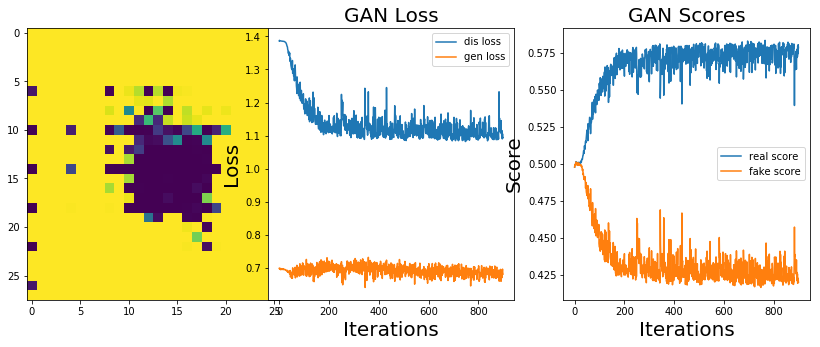

iter step: 899


KeyboardInterrupt: 

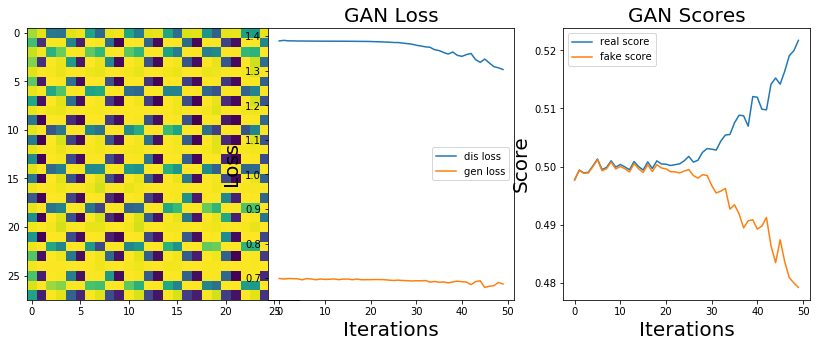

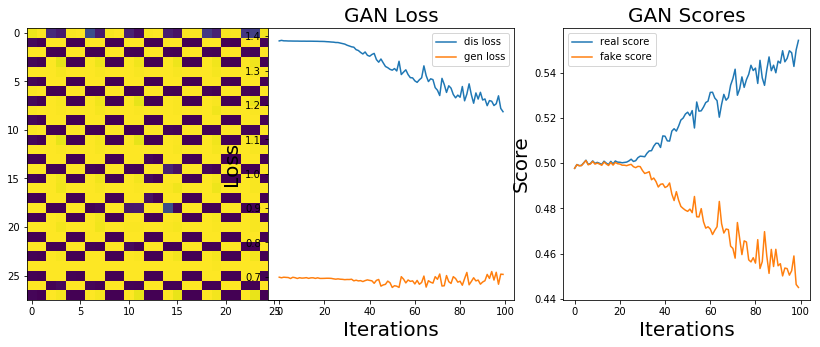

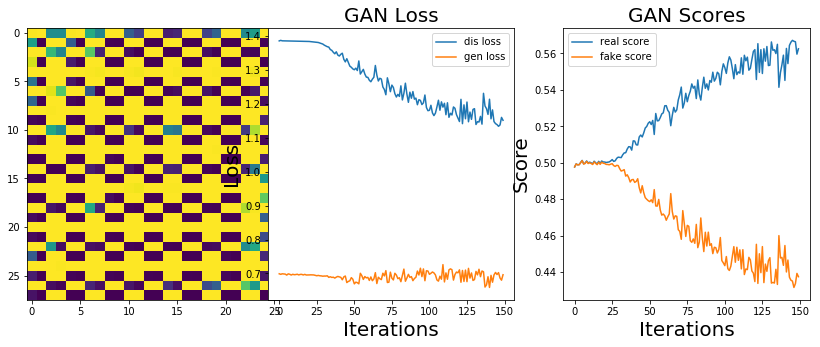

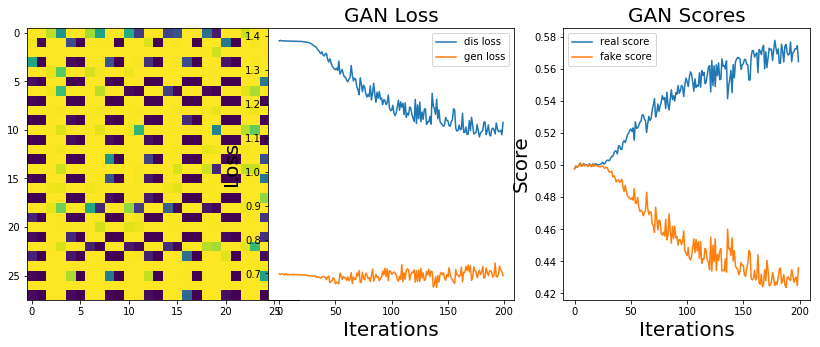

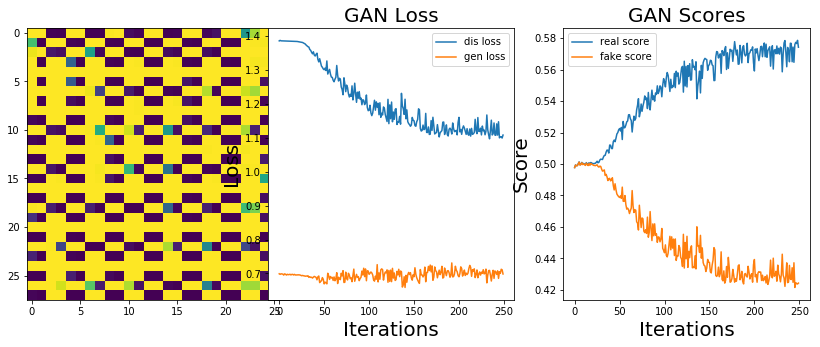

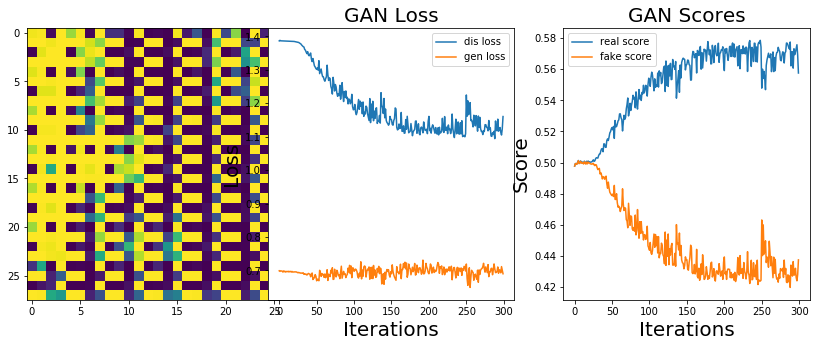

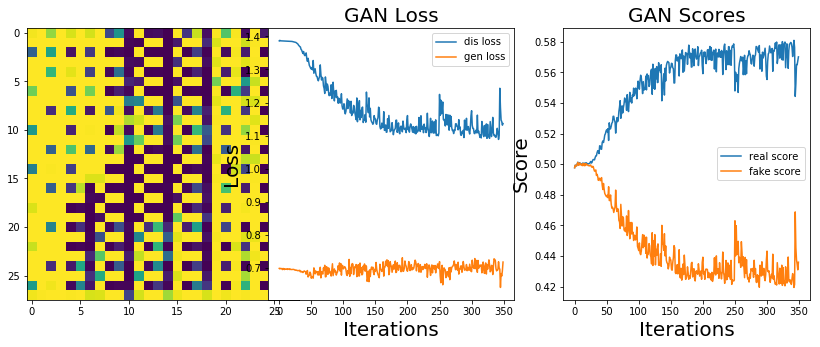

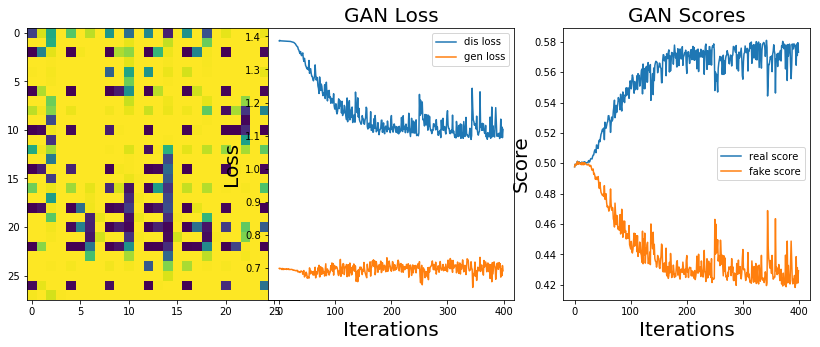

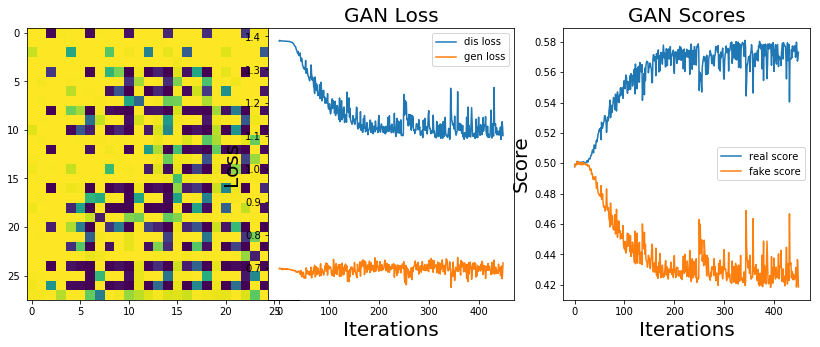

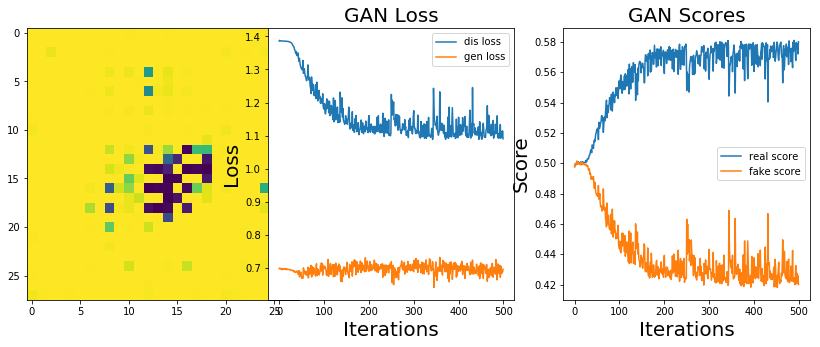

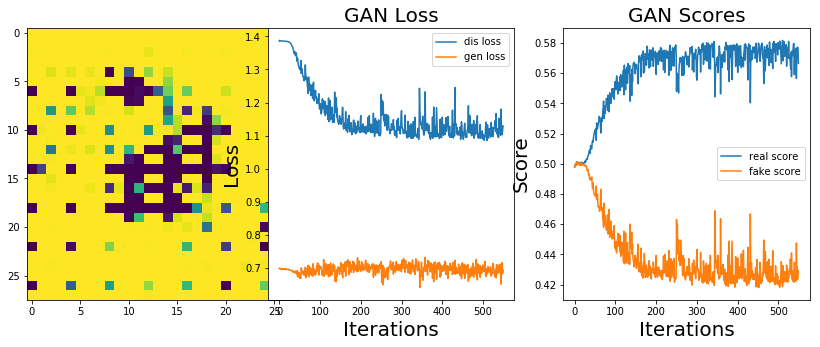

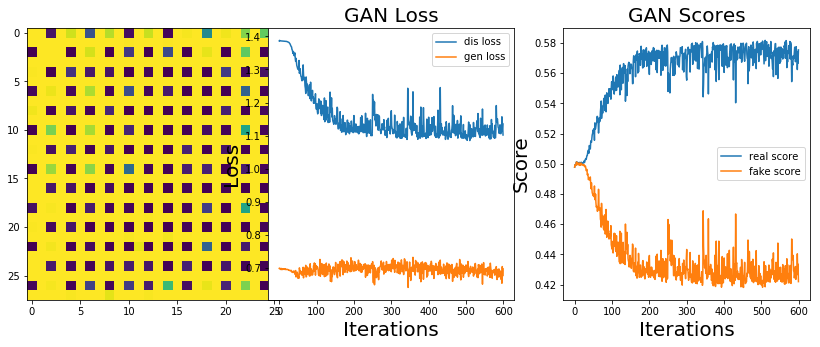

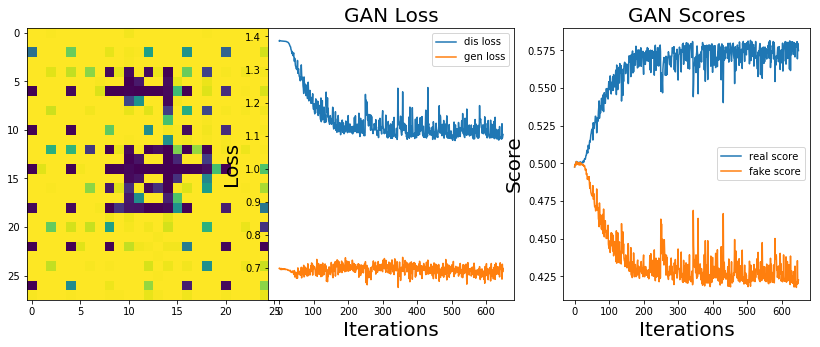

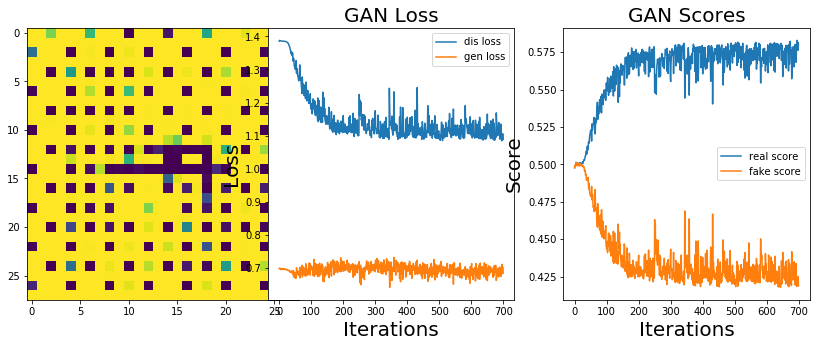

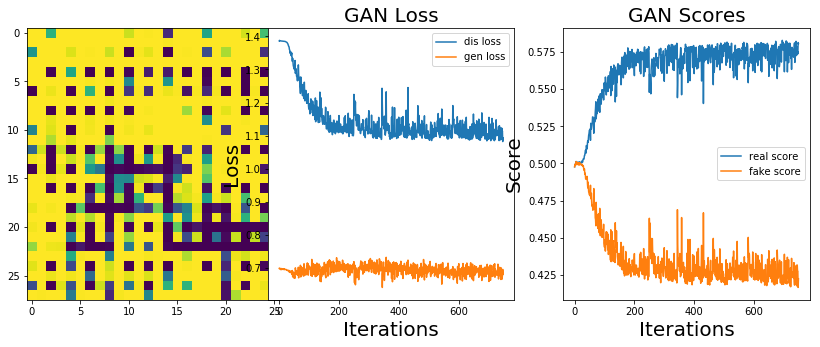

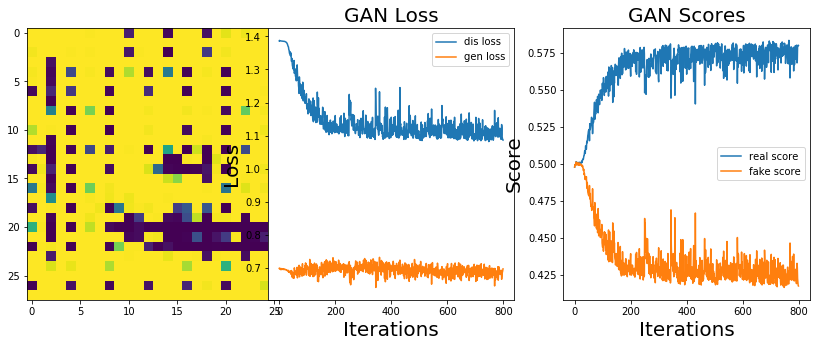

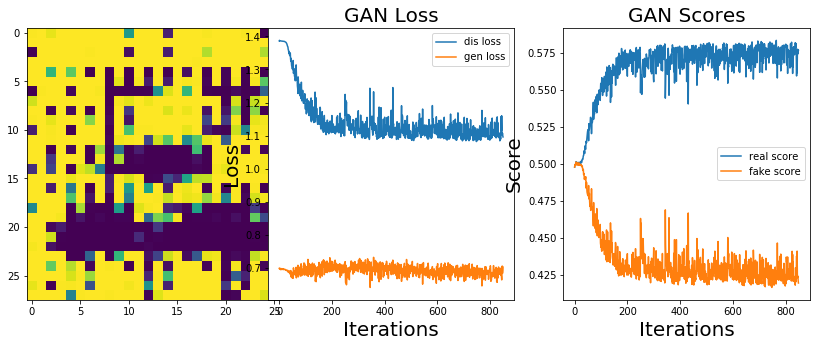

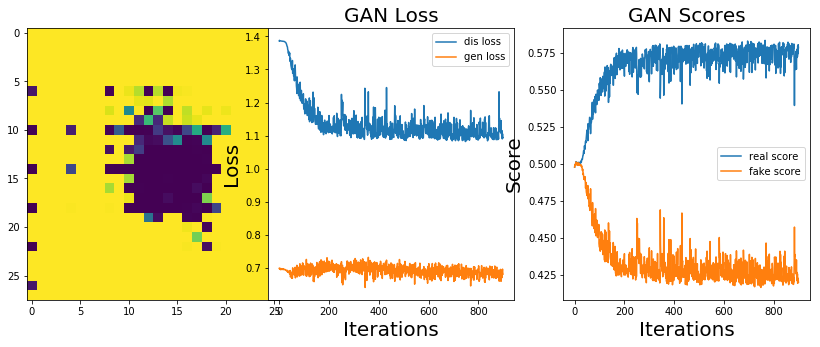

In [81]:

for i in range(niter):
    model.train(i)
#    print('training done!')



In [75]:
g = model.generator

In [76]:
nbatch = 10
nz = 100
epsilon = torch.randn(nbatch,nz)
epsilon = Variable(epsilon, requires_grad=False)

y = torch.zeros(nbatch,10)
temp = torch.from_numpy(np.random.choice(10,nbatch))
cuda = False
for i in range(nbatch):
    y[i,temp[i]] = 1
#     y[i,i] = 1
# y[:,1] = 1
y = Variable(y, requires_grad=False)
fake = g(epsilon,y)

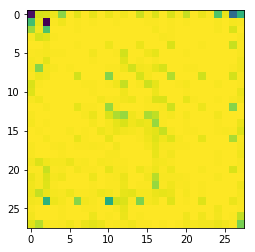

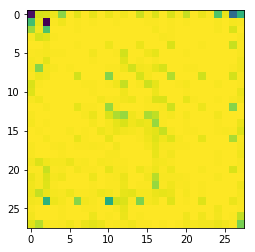

In [77]:
for i in range(nbatch):
    plt.imshow(fake[i].squeeze(1).data.cpu().numpy().reshape(28,28))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)